# Imports

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive/PHYS6060/ML_strategy/')

!pip install wandb
import wandb
from wandb.xgboost import WandbCallback
wandb.login(key="6dc78c7577f9146a1f008e276104f2f3afc9fda1")
#  6dc78c7577f9146a1f008e276104f2f3afc9fda1

from data import Data
from ML_Models import val_split, held_out

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


wandb: Currently logged in as: asorlik (asorliklab). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
path = "/content/gdrive/MyDrive/PHYS6060/ML_strategy/plots/"

# Data Processing

In [2]:
ticker = 'MSFT'
data = Data(tickers=[ticker], max=True, interval='1d')

FEATURES, TARGET = data.feature_matrix(ticker, target='dummy_binary', leak=False, scale=True)

print(FEATURES.columns)

# remove data for testing
FEATURES=FEATURES.drop(['Open', 'High', 'Low', 'Close',
       'quarter', 'year', 'dayofyear','Volume',
        'historical_volatility','SMA_10','Adj_close_ratio_quarter',
        'Volume_ratio_quarter','Adj_close_ratio_year', 'Volume_ratio_year',
       'SMA_30', 'EMA_10', 'EMA_30','Adj_close_first_diff', 'Volume_first_diff',
       'Adj_close_second_diff', 'Volume_second_diff', 'pct_lag_week',
       'pct_lag_quarter', 'pct_lag_year', 'Adj_lag_week', 'Adj_lag_quarter',
       'Adj_lag_year', 'Vol_lag_week', 'Vol_lag_quarter', 'Vol_lag_year'], axis=1)

print(FEATURES.columns)

# FEATURES[-5:]

[*********************100%%**********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume', 'dayofweek',
       'month', 'quarter', 'year', 'dayofyear', 'SMA_10', 'SMA_30', 'EMA_10',
       'EMA_30', 'RSI', 'MACD_signal_line', 'MACD_histogram',
       'historical_volatility', 'Adj_close_ratio_day', 'Volume_ratio_day',
       'Adj_close_ratio_week', 'Volume_ratio_week', 'Adj_close_ratio_month',
       'Volume_ratio_month', 'Adj_close_ratio_quarter', 'Volume_ratio_quarter',
       'Adj_close_ratio_year', 'Volume_ratio_year', 'Adj_close_first_diff',
       'Volume_first_diff', 'Adj_close_second_diff', 'Volume_second_diff',
       'pct_lag_week', 'pct_lag_quarter', 'pct_lag_year', 'Adj_lag_week',
       'Adj_lag_quarter', 'Adj_lag_year', 'Vol_lag_week', 'Vol_lag_quarter',
       'Vol_lag_year'],
      dtype='object')
Index(['Adj_close', 'dayofweek', 'month', 'RSI', 'MACD_signal_line',
       'MACD_histogram', 'Adj_close_ratio_day', 'Volume_ratio_day',

In [6]:
TARGET.sum() / TARGET.count()

0.6242299794661191

## Single Train/Test Split

In [22]:
# take only the last 100 market days
# FEATURES = FEATURES[-100:]
# TARGET = TARGET[-100:]

# FEATURES

In [3]:
# create a held out test set
print(len(FEATURES))
FEATURES, TARGET, X_test, Y_test = held_out(FEATURES, TARGET, test_size=100)
print(len(FEATURES), len(X_test))

9254
9154 100


In [4]:
training_data = val_split(FEATURES, TARGET, test_size=0.2, shuffle=False)
X_train, Y_train, X_val, Y_val = training_data['X_train'],  training_data['Y_train'],  training_data['X_val'],  training_data['Y_val']

In [26]:
len(X_val)+len(X_train)

9144

Now we have the training and validation: X_train, Y_train, X_val, Y_val \\
And the held out for testing: X_test, Y_test

# Cross-Validation Test

In [ ]:
# hold out the last 20 days as the final test set
X_test = FEATURES[-20:]
Y_test = TARGET[-20:]

FEATURES = FEATURES[:-20]
TARGET = TARGET[:-20]

# print(X_test.head())
# print(FEATURES.tail())

In [12]:
from sklearn.model_selection import cross_val_score

In [19]:
project_name = 'XGBoost_Binary_Cross_validation'
run_name = 'run_2'
run = wandb.init(
      # Set the project where this run will be logged
      project=project_name,
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=run_name,
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.01,
      "architecture": "Gradient Boosting",
      "objective":"binary:logistic",
      "eval_metrics":['logloss', 'error'],
      "dataset": ticker,
      "epochs": 1000
      })


# define model
reg = xgb.XGBClassifier(n_estimators=1000, eta=0.01,objective='binary:logistic',
                        eval_metric=['logloss', 'error'],
                         callbacks=[WandbCallback()])

n_folds = 10

tss = TimeSeriesSplit(n_splits=n_folds, test_size=100)

cv_scores = cross_val_score(reg, FEATURES, TARGET, cv=tss, scoring='accuracy', verbose=100)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print(f"Mean Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation: {cv_scores.std():.2f}")

run.finish()

[CV] START .....................................................................
[CV] END ................................ score: (test=0.780) total time=   8.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.2s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.750) total time=   9.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   17.2s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.800) total time=  10.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   27.3s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.810) total time=   6.6s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   33.9s
[CV] START .....................................................................
[CV] END ..................

epoch,▂▃▅▆▁▃▅▇▁▃▅▇▁▃▅▇▂▃▅▇▂▄▅▇▂▄▆▇▂▄▆█▂▄▆█▂▄▆█
epoch,999


In [ ]:
# for train_i, val_i in tss.split(FEATURES):
#     X_train, X_val = FEATURES[train_i], FEATURES[val_i]
#     Y_train, Y_val = TARGET[train_i], TARGET[val_i]

# Binary Model

[0]	validation_0-logloss:0.66048	validation_0-error:0.38174	validation_1-logloss:0.65788	validation_1-error:0.37588
[100]	validation_0-logloss:0.44713	validation_0-error:0.19851	validation_1-logloss:0.47316	validation_1-error:0.20930
[200]	validation_0-logloss:0.38794	validation_0-error:0.17106	validation_1-logloss:0.43433	validation_1-error:0.22336
[300]	validation_0-logloss:0.36369	validation_0-error:0.15943	validation_1-logloss:0.42476	validation_1-error:0.22174
[400]	validation_0-logloss:0.34732	validation_0-error:0.14767	validation_1-logloss:0.42663	validation_1-error:0.22553
[500]	validation_0-logloss:0.33081	validation_0-error:0.13212	validation_1-logloss:0.43117	validation_1-error:0.22877
[600]	validation_0-logloss:0.31728	validation_0-error:0.11832	validation_1-logloss:0.43472	validation_1-error:0.22823
[700]	validation_0-logloss:0.30741	validation_0-error:0.11237	validation_1-logloss:0.43725	validation_1-error:0.22715
[800]	validation_0-logloss:0.29824	validation_0-error:0.10

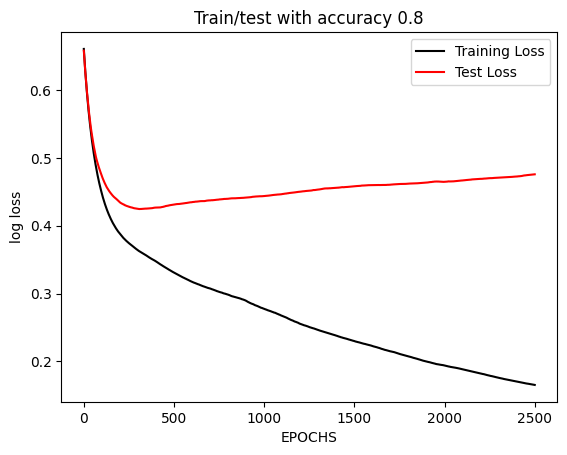

<Figure size 640x480 with 0 Axes>

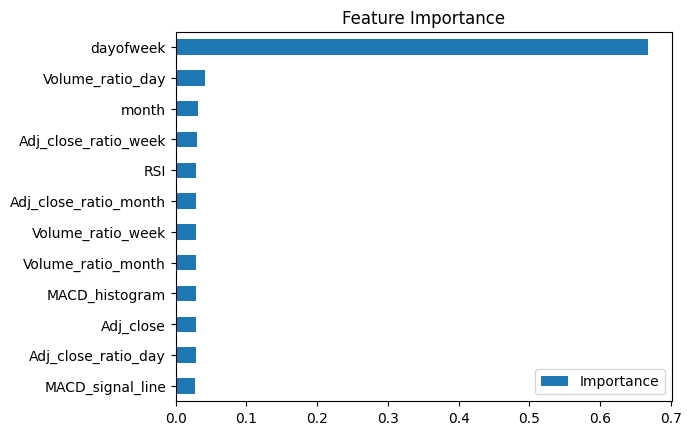

<Figure size 640x480 with 0 Axes>

In [14]:
preds = []
acc = []
scores = []

# project_name = 'XGBoost_Binary_DUMMY_TARGET_TEST'
# run_name = 'run_0'
# run = wandb.init(
#       # Set the project where this run will be logged
#       project=project_name,
#       # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#       name=run_name,
#       # Track hyperparameters and run metadata
#       config={
#       "learning_rate": 0.01,
#       "architecture": "Gradient Boosting",
#       "objective":"binary:logistic",
#       "eval_metrics":['logloss', 'error'],
#       "dataset": ticker,
#       "epochs": 2000
#       })


reg = xgb.XGBClassifier(n_estimators=2500, eta=0.01,objective='binary:logistic',
                        eval_metric=['logloss', 'error'])

reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train),(X_val, Y_val)],
        # early_stopping_rounds=100,
        verbose=100)

# reg.fit(X_train, Y_train,
#         eval_set=[(X_train, Y_train),(X_test, Y_test)],
#         # early_stopping_rounds=100,
#         verbose=100,
#         callbacks=[WandbCallback(log_model=True)])

y_pred = reg.predict(X_test)
preds.append(y_pred)

Y_pred = pd.Series(y_pred, index=Y_test.index)
# accuracy = (Y_pred == Y_test).sum() / Y_test.count()
accuracy = reg.score(X_test, Y_test)
acc.append(accuracy)

score = np.sqrt(mean_squared_error(Y_test, y_pred))
scores.append(score)

results = reg.evals_result()
training_accuracy = 1-np.array(results['validation_0']['error'])
plt.plot(results['validation_0']['logloss'], color='k', label='Training Loss')
# plt.plot(training_accuracy, color='k', ls='--', label='Training Accuracy')
plt.plot(results['validation_1']['logloss'], color='red', label='Test Loss')
plt.xlabel("EPOCHS")
plt.ylabel("log loss")
plt.title(f'Train/test with accuracy {accuracy}')
plt.legend()
plt.show()
plt.clf()
# feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['Importance'])
fi.sort_values("Importance").plot(kind='barh', title='Feature Importance')
plt.show()
plt.clf()

# run.finish()

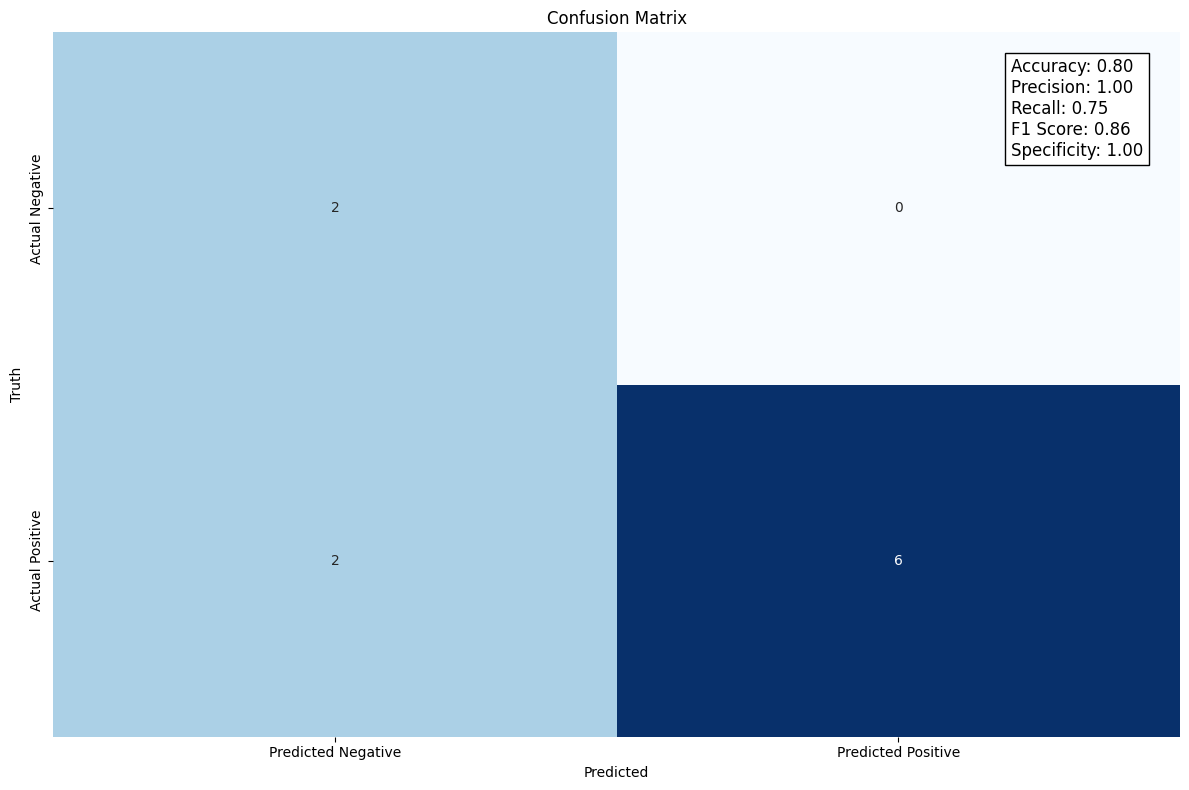

In [15]:
from ML_Models import error_matrix

error_matrix(Y_test, y_pred)

In [ ]:
# train_pred = reg.predict(X_train)
# test_pred = reg.predict(X_test)
# plt.figure(figsize=(12,6))

# # # Plot training predictions and targets
# # plt.scatter(Y_train.index, train_pred+0.1, label="Training Predictions", color="blue")
# # plt.scatter(Y_train.index, Y_train.values, label="Training Targets", color="green")

# # # Add a vertical line to indicate the transition from training to test data
# # plt.axvline(x=len(train_pred), color="red", linestyle="-.", label="Training/Test Transition")

# # Plot test predictions and targets
# plt.scatter(Y_test.index, test_pred+0.01, label="Test Predictions", color="orange")
# plt.scatter(Y_test.index, Y_test.values, label="Test Targets", color="purple")

# # Add legend
# plt.legend()

# # Show the plot
# plt.show()

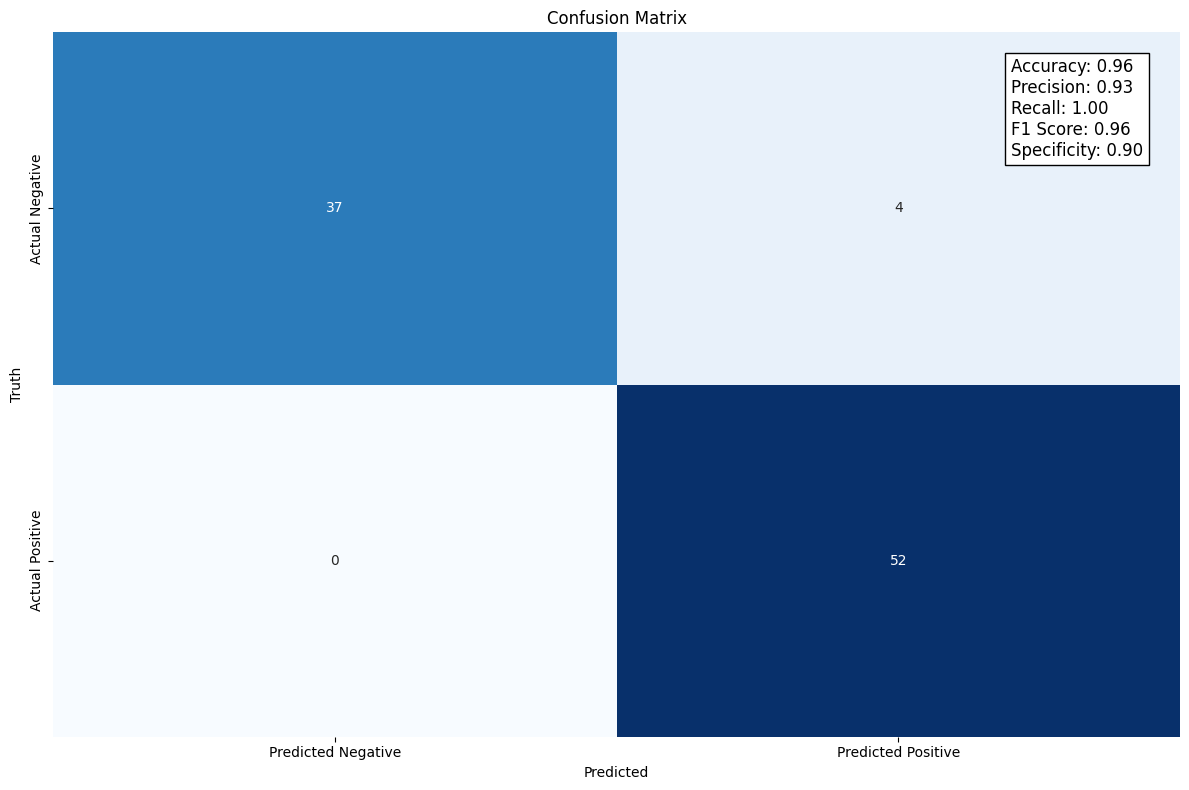

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y_test, y_pred)
TN = conf_matrix[0,0]
TP = conf_matrix[1,1]
FN = conf_matrix[1,0]
FP = conf_matrix[0,1]

recall = TP / (TP+FN) # correctly identify positives
precision = TP / (TP+FP) # positive only
specificity = TN / (TN+FP) # negative only
f1 = 2 * (precision*recall) / (precision+recall)
accuracy = np.isclose(Y_test, y_pred).sum() / len(Y_test)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
metrics_text = f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}\nSpecificity: {specificity:.2f}'
plt.text(1.7, 0.35, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=1))
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')


plt.tight_layout()
# plt.savefig(path + 'XGBoost_BINARY_DUMMY_confusion_matrix.pdf')

plt.show()

In [15]:


print(
    'recall ', recall, '\n',
    'precision ', precision, '\n',
    'specificity ', specificity, '\n',
    'f1 ', f1
)

recall  0.6842105263157895 
 precision  0.65 
 specificity  0.9054054054054054 
 f1  0.6666666666666667


In [16]:
accuracy = np.isclose(Y_test, y_pred).sum() / len(Y_test)
print(accuracy)

0.8602150537634409


## Custom threshold for true positives

In [131]:
probs = reg.predict_proba(X_test)

custom_threshold = 0.7

positive_vals = probs[:,1]

custom_preds = (positive_vals >= custom_threshold).astype(int)

custom_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [132]:
accuracy = np.isclose(Y_test, custom_preds).sum() / len(Y_test)
print(accuracy)

0.41935483870967744


## Using TimeSeriesSplit

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69188	validation_0-error:0.48094	validation_1-logloss:0.67885	validation_1-error:0.30000
[100]	validation_0-logloss:0.65675	validation_0-error:0.33317	validation_1-logloss:0.68193	validation_1-error:0.35000
[200]	validation_0-logloss:0.63555	validation_0-error:0.28892	validation_1-logloss:0.68703	validation_1-error:0.40000
[300]	validation_0-logloss:0.61377	validation_0-error:0.26034	validation_1-logloss:0.68153	validation_1-error:0.35000
[400]	validation_0-logloss:0.59604	validation_0-error:0.23224	validation_1-logloss:0.67912	validation_1-error:0.40000
[500]	validation_0-logloss:0.58100	validation_0-error:0.20930	validation_1-logloss:0.68020	validation_1-error:0.40000
[600]	validation_0-logloss:0.56578	validation_0-error:0.18233	validation_1-logloss:0.67570	validation_1-error:0.50000
[700]	validation_0-logloss:0.54993	validation_0-error:0.16021	validation_1-logloss:0.67266	validation_1-error:0.50000
[800]	validation_0-logloss:0.53434	validation_0-error:0.14

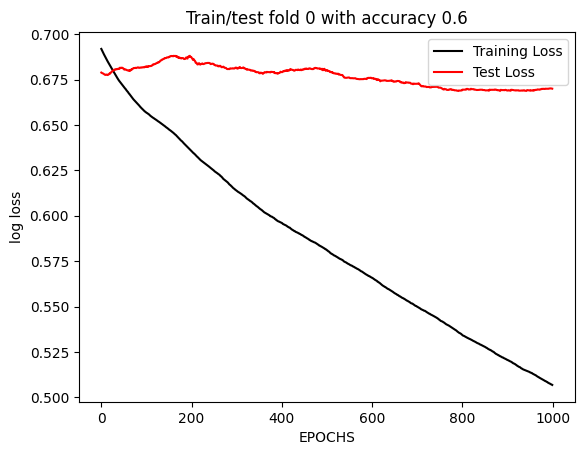

<Figure size 640x480 with 0 Axes>

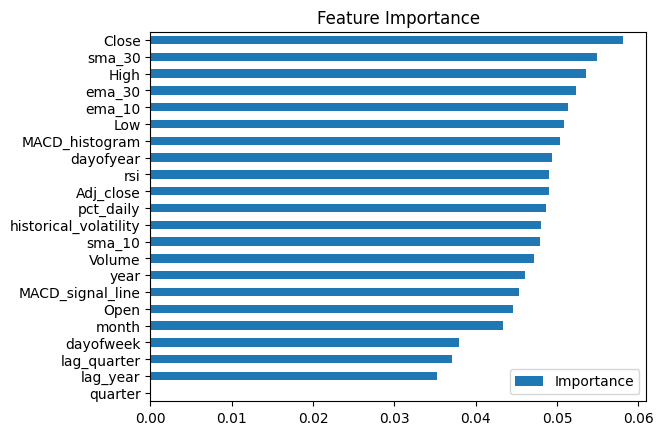

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-error,█▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_0-logloss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
validation_1-error,▁▂▂▂▂▄▄▄▄▄▄▄▂▄▅▄▄▄▄▄▄▄▇▇▇▇▇▇▇▇▇███▇▅▅▅▅▄
validation_1-logloss,▄▅▅▆▆▇█▇▇▇▆▅▆▅▅▅▅▅▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,999


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69193	validation_0-error:0.48052	validation_1-logloss:0.70943	validation_1-error:0.70000
[100]	validation_0-logloss:0.65707	validation_0-error:0.33194	validation_1-logloss:0.71229	validation_1-error:0.45000
[200]	validation_0-logloss:0.63302	validation_0-error:0.28203	validation_1-logloss:0.71867	validation_1-error:0.60000
[300]	validation_0-logloss:0.61344	validation_0-error:0.25757	validation_1-logloss:0.72401	validation_1-error:0.65000
[400]	validation_0-logloss:0.59334	validation_0-error:0.22263	validation_1-logloss:0.72517	validation_1-error:0.60000
[500]	validation_0-logloss:0.57418	validation_0-error:0.18851	validation_1-logloss:0.72032	validation_1-error:0.55000
[600]	validation_0-logloss:0.55697	validation_0-error:0.16935	validation_1-logloss:0.72567	validation_1-error:0.55000
[700]	validation_0-logloss:0.54064	validation_0-error:0.15132	validation_1-logloss:0.72356	validation_1-error:0.45000
[800]	validation_0-logloss:0.52514	validation_0-error:0.13

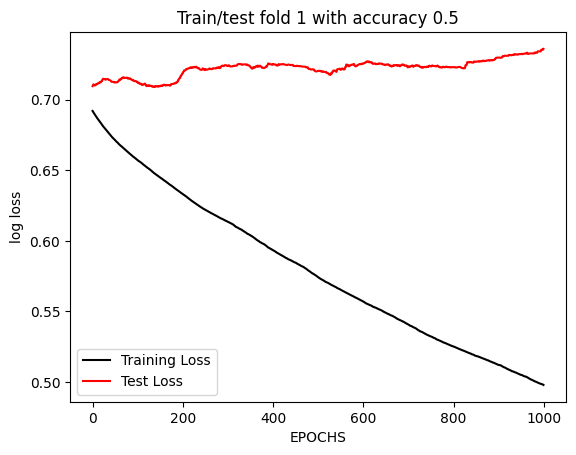

<Figure size 640x480 with 0 Axes>

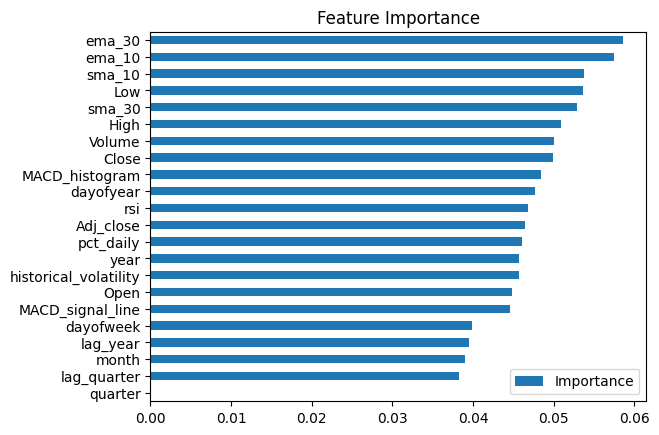

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-error,█▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation_0-logloss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
validation_1-error,█▅▃▃▃▃▁▃▆▆▆▅▇▆▆▅▆▆▆▅▅▅▅▅▄▄▃▄▃▂▂▂▃▃▃▄▄▄▄▄
validation_1-logloss,▁▂▂▂▂▁▁▂▄▅▄▅▅▅▅▅▅▅▅▄▄▄▄▅▆▅▅▅▅▅▅▅▅▆▆▇▇▇██
epoch,999


[0]	validation_0-logloss:0.69184	validation_0-error:0.48107	validation_1-logloss:0.69020	validation_1-error:0.45000


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.65629	validation_0-error:0.33119	validation_1-logloss:0.69262	validation_1-error:0.50000
[200]	validation_0-logloss:0.63338	validation_0-error:0.29060	validation_1-logloss:0.70641	validation_1-error:0.60000
[300]	validation_0-logloss:0.61154	validation_0-error:0.25465	validation_1-logloss:0.71085	validation_1-error:0.60000
[400]	validation_0-logloss:0.59175	validation_0-error:0.22786	validation_1-logloss:0.72973	validation_1-error:0.60000
[500]	validation_0-logloss:0.57589	validation_0-error:0.20571	validation_1-logloss:0.73329	validation_1-error:0.55000
[600]	validation_0-logloss:0.55829	validation_0-error:0.17603	validation_1-logloss:0.73890	validation_1-error:0.55000
[700]	validation_0-logloss:0.54307	validation_0-error:0.15709	validation_1-logloss:0.74999	validation_1-error:0.55000
[800]	validation_0-logloss:0.52762	validation_0-error:0.14393	validation_1-logloss:0.75494	validation_1-error:0.50000
[900]	validation_0-logloss:0.51299	validation_0-error:0.

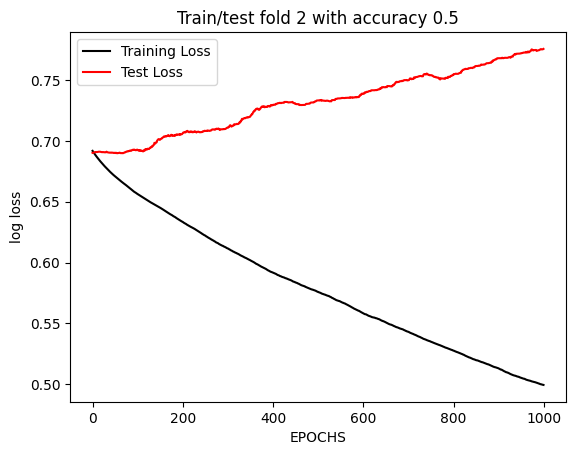

<Figure size 640x480 with 0 Axes>

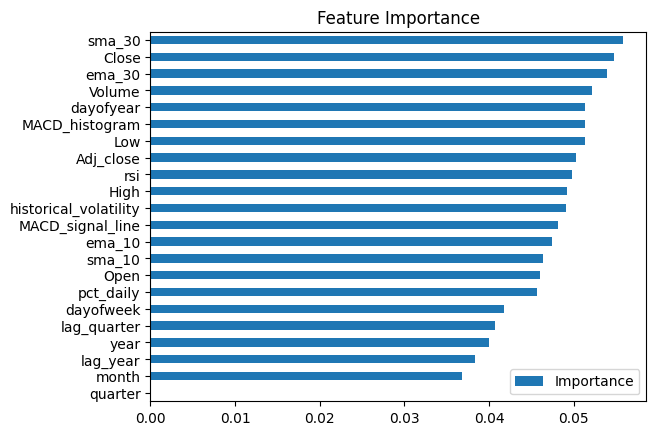

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-error,█▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation_0-logloss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
validation_1-error,▁▃▃▁▁▃▃███████████▆▆▆▆▆▆▆▆▆▆▆▃▃▃▃▃▃▃▃▃▃▃
validation_1-logloss,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
epoch,999


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69192	validation_0-error:0.48097	validation_1-logloss:0.69151	validation_1-error:0.45000
[100]	validation_0-logloss:0.65619	validation_0-error:0.33301	validation_1-logloss:0.71944	validation_1-error:0.55000
[200]	validation_0-logloss:0.63375	validation_0-error:0.29591	validation_1-logloss:0.73787	validation_1-error:0.60000
[300]	validation_0-logloss:0.61345	validation_0-error:0.26376	validation_1-logloss:0.76596	validation_1-error:0.70000
[400]	validation_0-logloss:0.59293	validation_0-error:0.22937	validation_1-logloss:0.78808	validation_1-error:0.75000
[500]	validation_0-logloss:0.57402	validation_0-error:0.20026	validation_1-logloss:0.79562	validation_1-error:0.70000
[600]	validation_0-logloss:0.55728	validation_0-error:0.17402	validation_1-logloss:0.79490	validation_1-error:0.65000
[700]	validation_0-logloss:0.54379	validation_0-error:0.15643	validation_1-logloss:0.78770	validation_1-error:0.65000
[800]	validation_0-logloss:0.53047	validation_0-error:0.14

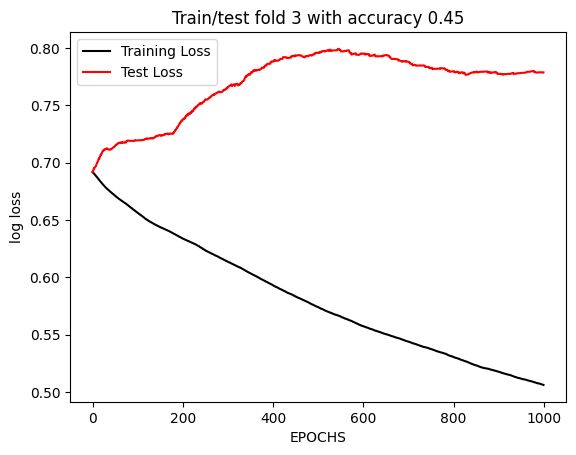

<Figure size 640x480 with 0 Axes>

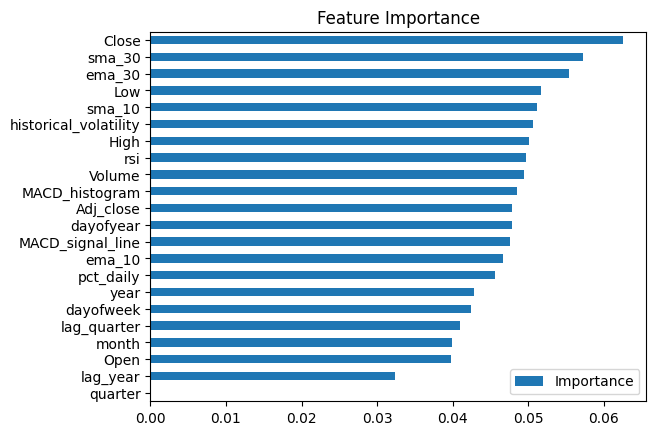

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-error,█▇▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation_0-logloss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
validation_1-error,▁▃▃▅▃▃▅▃▅▆▆▇▇▆▇▇██▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▃▃▃▃▃
validation_1-logloss,▁▂▂▃▃▃▃▃▄▅▅▆▆▆▇▇▇█████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,999


[0]	validation_0-logloss:0.69194	validation_0-error:0.48103	validation_1-logloss:0.69309	validation_1-error:0.50000


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.65765	validation_0-error:0.34295	validation_1-logloss:0.68333	validation_1-error:0.40000
[200]	validation_0-logloss:0.63586	validation_0-error:0.30118	validation_1-logloss:0.68920	validation_1-error:0.45000
[300]	validation_0-logloss:0.61290	validation_0-error:0.25606	validation_1-logloss:0.70514	validation_1-error:0.50000
[400]	validation_0-logloss:0.59432	validation_0-error:0.22561	validation_1-logloss:0.70099	validation_1-error:0.50000
[500]	validation_0-logloss:0.57655	validation_0-error:0.19643	validation_1-logloss:0.70531	validation_1-error:0.45000
[600]	validation_0-logloss:0.56161	validation_0-error:0.17474	validation_1-logloss:0.71383	validation_1-error:0.55000
[700]	validation_0-logloss:0.54799	validation_0-error:0.15960	validation_1-logloss:0.71729	validation_1-error:0.55000
[800]	validation_0-logloss:0.53268	validation_0-error:0.14493	validation_1-logloss:0.71714	validation_1-error:0.50000
[900]	validation_0-logloss:0.51808	validation_0-error:0.

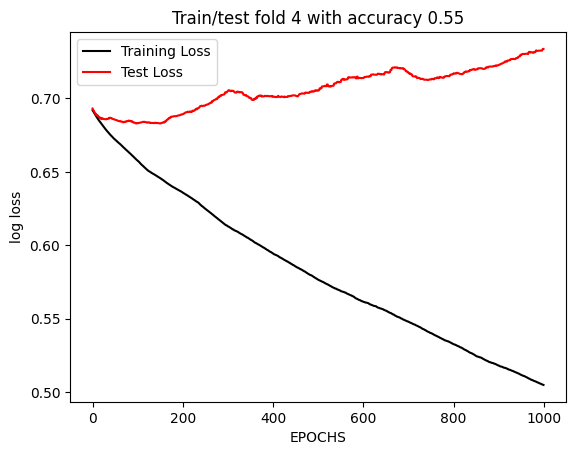

<Figure size 640x480 with 0 Axes>

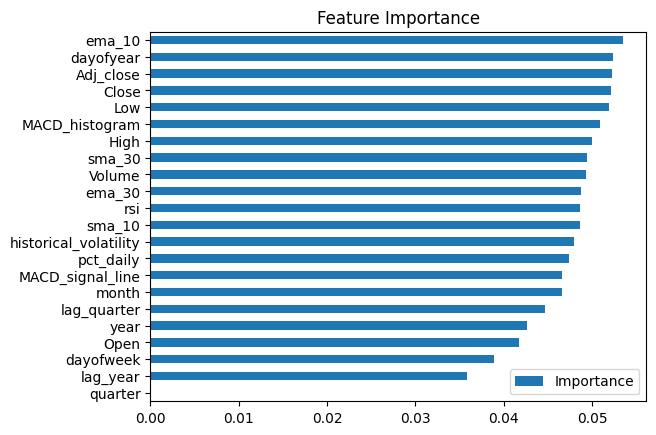

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-error,█▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_0-logloss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
validation_1-error,▃▁▁▁▁▁▁▃▃▆▆▆▆▆▆▆▆▃▃▃▃▆▆█████▆▆▆▆▆▆▃▃▃▃▃▃
validation_1-logloss,▂▁▁▁▁▁▁▂▂▂▃▃▄▄▃▄▄▄▄▄▅▅▅▅▆▆▆▆▅▅▅▆▆▆▆▇▇▇██
epoch,999


<Figure size 640x480 with 0 Axes>

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=1*20, gap=1)
df = df.sort_index()

fold = 0
preds = []
acc = []
scores = []

# weights and biases
project_name = f'XGBoost_Binary_Model_Trailing_Target_{ticker}'


for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    run = wandb.init(
      # Set the project where this run will be logged
      project=project_name,
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"splits_{fold}",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.01,
      "architecture": "Gradient Boosting",
      "objective":"binary:logistic",
      "eval_metrics":['logloss', 'error'],
      "dataset": ticker,
      "epochs": 1000,
      })

    FEATURES = ['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume', 'dayofweek',
       'month', 'quarter', 'year', 'dayofyear', 'sma_10', 'sma_30', 'ema_10',
       'ema_30', 'rsi','pct_daily','MACD_signal_line', 'MACD_histogram',
       'historical_volatility', 'lag_quarter', 'lag_year']

    TARGET = 'TARGET'

    X_train = train[FEATURES]
    Y_train = train[TARGET]

    X_test = test[FEATURES]
    Y_test = test[TARGET]

    # weights and biases

    # reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, objective='reg:linear',
    #                        max_depth=2, learning_rate=0.01)

    reg = xgb.XGBClassifier(n_estimators=1000, eta=0.01,objective='binary:logistic', eval_metric=['logloss', 'error'])

    reg.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train),(X_test, Y_test)],
            # early_stopping_rounds=100,
            verbose=100,
            callbacks=[WandbCallback(log_model=True)])
    # reg.fit(X_train, Y_train,
    #     eval_set=[(X_train, Y_train),(X_test, Y_test)],
    #     # early_stopping_rounds=100,
    #     verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    Y_pred = pd.Series(y_pred, index=Y_test.index)
    # accuracy = (Y_pred == Y_test).sum() / Y_test.count()
    accuracy = reg.score(X_test, Y_test)
    acc.append(accuracy)

    score = np.sqrt(mean_squared_error(Y_test, y_pred))
    scores.append(score)

    results = reg.evals_result()
    training_accuracy = 1-np.array(results['validation_0']['error'])
    plt.plot(results['validation_0']['logloss'], color='k', label='Training Loss')
    # plt.plot(training_accuracy, color='k', ls='--', label='Training Accuracy')
    plt.plot(results['validation_1']['logloss'], color='red', label='Test Loss')
    plt.xlabel("EPOCHS")
    plt.ylabel("log loss")
    plt.title(f'Train/test fold {fold} with accuracy {accuracy}')
    plt.legend()
    plt.show()
    plt.clf()
    # feature importance
    fi = pd.DataFrame(data=reg.feature_importances_,
                index=reg.feature_names_in_,
                columns=['Importance'])
    fi.sort_values("Importance").plot(kind='barh', title='Feature Importance')
    plt.show()
    plt.clf()
    fold+=1
    run.finish()


In [ ]:
reg.predict_proba(X_test)

array([[0.42214572, 0.5778543 ],
       [0.5122298 , 0.48777023],
       [0.4920358 , 0.5079642 ],
       [0.45294428, 0.5470557 ],
       [0.36794132, 0.6320587 ],
       [0.40992433, 0.5900757 ],
       [0.359578  , 0.640422  ],
       [0.2515899 , 0.7484101 ],
       [0.2363478 , 0.7636522 ],
       [0.21680027, 0.7831997 ],
       [0.47714972, 0.5228503 ],
       [0.39226753, 0.6077325 ],
       [0.42504323, 0.5749568 ],
       [0.4169976 , 0.5830024 ],
       [0.3899511 , 0.6100489 ],
       [0.41243774, 0.58756226],
       [0.39623058, 0.6037694 ],
       [0.42460185, 0.57539815],
       [0.22337794, 0.77662206],
       [0.45218647, 0.54781353]], dtype=float32)

In [ ]:
y_pred

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
acc

[0.6, 0.5, 0.5, 0.45, 0.55]

In [ ]:
np.mean(acc)

0.5200000000000001

In [ ]:
pred_0 = preds[0]
preds0 = pd.Series(pred_0, index=Y_test_0.index)
preds0

Date
2023-09-06    1
2023-09-07    1
2023-09-08    1
2023-09-11    1
2023-09-12    1
2023-09-13    1
2023-09-14    1
2023-09-15    0
2023-09-18    0
2023-09-19    0
dtype: int64

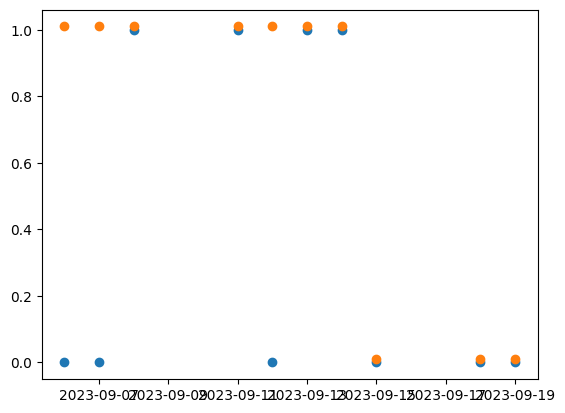

In [ ]:
plt.scatter(Y_test_0.index,Y_test_0)
plt.scatter(preds0.index, preds0+0.01)

In [ ]:
accurarcy = ((Y_test_0 == preds0).sum() / Y_test_0.count()) *100
print(accurarcy)

70.0


# Predict the Future

## Train model with all data up to today

# Regression Model

[0]	validation_0-rmse:0.01423	validation_0-mae:0.01097	validation_1-rmse:0.01411	validation_1-mae:0.01226
[100]	validation_0-rmse:0.00759	validation_0-mae:0.00571	validation_1-rmse:0.01361	validation_1-mae:0.01208
[200]	validation_0-rmse:0.00422	validation_0-mae:0.00312	validation_1-rmse:0.01491	validation_1-mae:0.01323
[300]	validation_0-rmse:0.00242	validation_0-mae:0.00175	validation_1-rmse:0.01537	validation_1-mae:0.01367
[400]	validation_0-rmse:0.00141	validation_0-mae:0.00098	validation_1-rmse:0.01567	validation_1-mae:0.01396
[500]	validation_0-rmse:0.00087	validation_0-mae:0.00062	validation_1-rmse:0.01585	validation_1-mae:0.01415
[600]	validation_0-rmse:0.00063	validation_0-mae:0.00046	validation_1-rmse:0.01601	validation_1-mae:0.01429
[700]	validation_0-rmse:0.00063	validation_0-mae:0.00046	validation_1-rmse:0.01601	validation_1-mae:0.01429
[800]	validation_0-rmse:0.00063	validation_0-mae:0.00046	validation_1-rmse:0.01601	validation_1-mae:0.01429
[900]	validation_0-rmse:0.0006

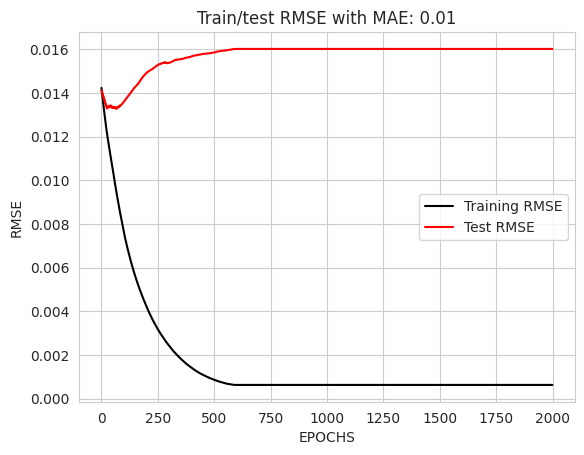

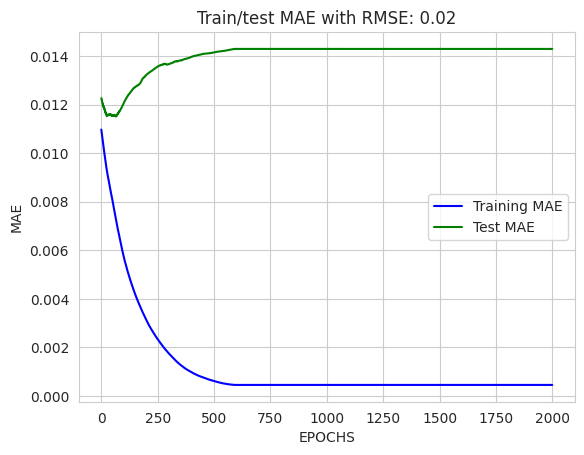

<Figure size 640x480 with 0 Axes>

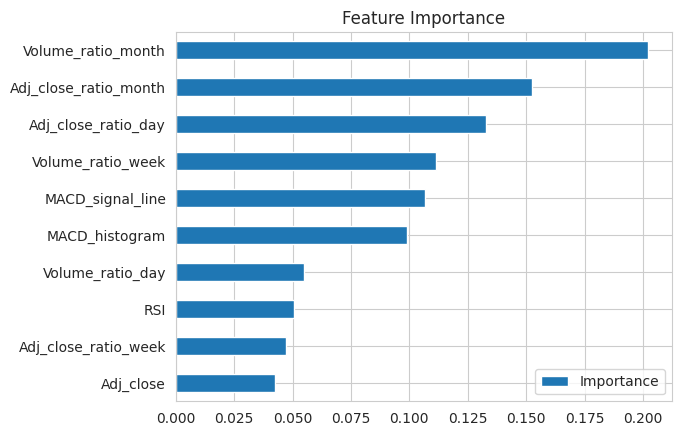

<Figure size 640x480 with 0 Axes>

In [70]:
# project_name = 'XGBoost_Binary_Leakage_TEST'
# run_name = 'unscaled'

preds = []
acc = []
scores = []
mae_scores = []

# run = wandb.init(
#       # Set the project where this run will be logged
#       project=project_name,
#       # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#       name=run_name,
#       # Track hyperparameters and run metadata
#       config={
#       "learning_rate": 0.01,
#       "architecture": "Gradient Boosting",
#       "objective":"binary:logistic",
#       "eval_metrics":['logloss', 'error'],
#       "dataset": ticker,
#       "epochs": 5000
#       })


# Create the regression model with regularization parameters
reg = xgb.XGBRegressor(n_estimators=2000, eta=0.01, objective='reg:squarederror',
                       eval_metric=['rmse', 'mae'],
                       reg_lambda=1.0)

# Fit the model
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        # early_stopping_rounds=100,
        verbose=100)

# reg.fit(X_train, Y_train,
#         eval_set=[(X_train, Y_train),(X_test, Y_test)],
#         # early_stopping_rounds=100,
#         verbose=100,
#         callbacks=[WandbCallback(log_model=True)])

y_pred = reg.predict(X_test)
preds.append(y_pred)

Y_pred = pd.Series(y_pred, index=Y_test.index)

# RMSE
rmse_score = np.sqrt(mean_squared_error(Y_test, y_pred))
scores.append(rmse_score)

# MAE
mae_score = mean_absolute_error(Y_test, y_pred)
mae_scores.append(mae_score)

results = reg.evals_result()
plt.plot(results['validation_0']['rmse'], color='k', label='Training RMSE')
plt.plot(results['validation_1']['rmse'], color='red', label='Test RMSE')
plt.xlabel("EPOCHS")
plt.ylabel("RMSE")
plt.title(f'Train/test RMSE with MAE: {mae_score:.2f}')
plt.legend()
plt.show()
plt.clf()

# If you want to plot MAE as well, you can add:
plt.plot(results['validation_0']['mae'], color='blue', label='Training MAE')
plt.plot(results['validation_1']['mae'], color='green', label='Test MAE')
plt.xlabel("EPOCHS")
plt.ylabel("MAE")
plt.title(f'Train/test MAE with RMSE: {rmse_score:.2f}')
plt.legend()
plt.show()
plt.clf()
# feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['Importance'])
fi.sort_values("Importance").plot(kind='barh', title='Feature Importance')
plt.show()
plt.clf()

# run.finish()

## Predictions

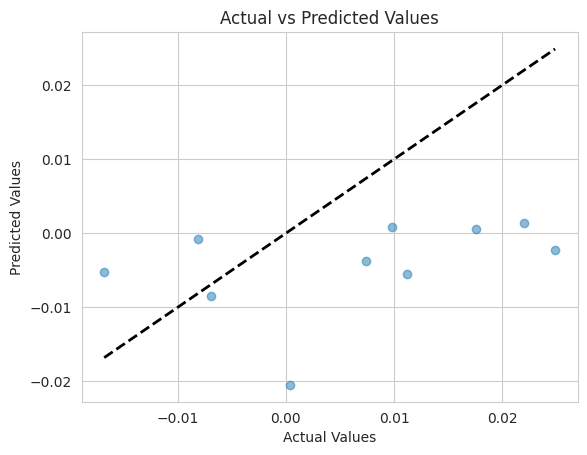

In [71]:
# Scatter plot
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)  # Diagonal line
plt.show()

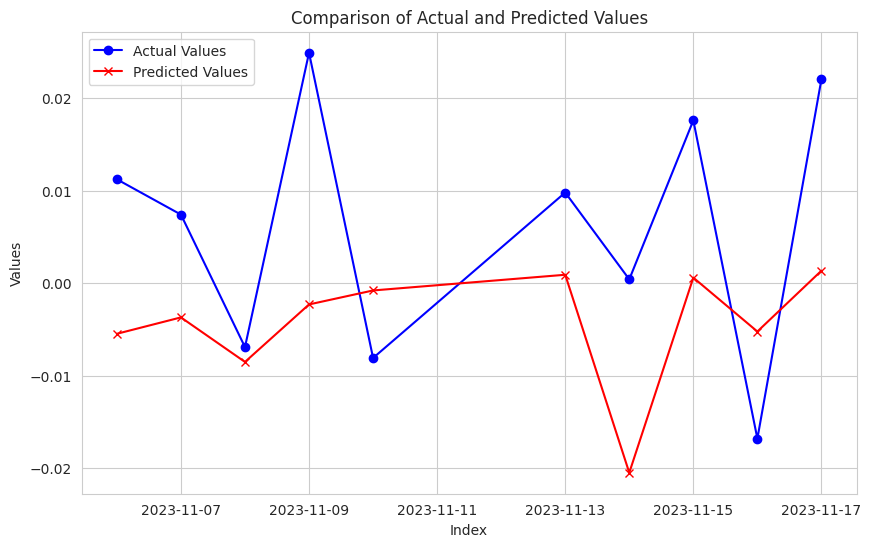

In [72]:
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue', marker='o')
plt.plot(Y_test.index, y_pred, label='Predicted Values', color='red', marker='x')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

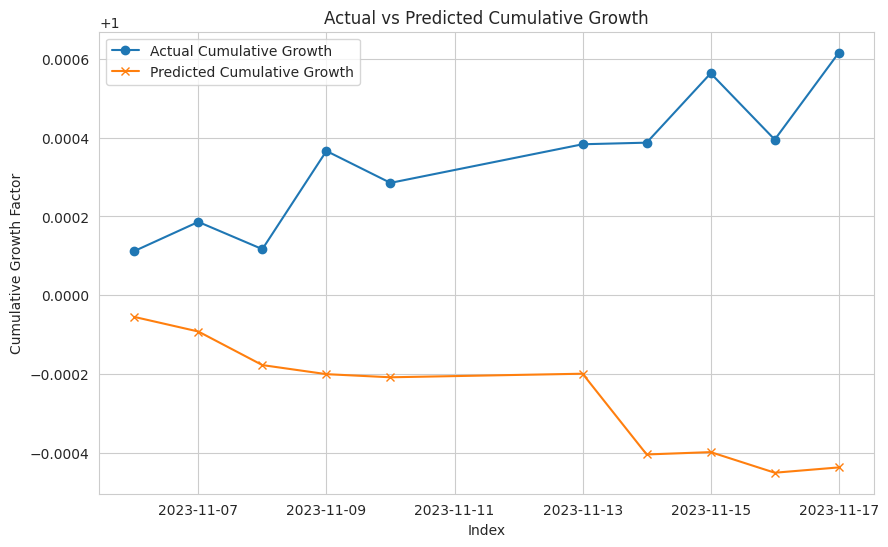

In [73]:
# Convert percentage changes to growth factors
growth_factors_actual = 1 + Y_test / 100
growth_factors_pred = 1 + y_pred / 100

# Calculate cumulative product to see compounded growth
cumulative_growth_actual = growth_factors_actual.cumprod()
cumulative_growth_pred = growth_factors_pred.cumprod()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cumulative_growth_actual.index, cumulative_growth_actual, label='Actual Cumulative Growth', marker='o')
plt.plot(cumulative_growth_actual.index, cumulative_growth_pred, label='Predicted Cumulative Growth', marker='x')
plt.xlabel('Index')
plt.ylabel('Cumulative Growth Factor')
plt.title('Actual vs Predicted Cumulative Growth')
plt.legend()
plt.show()

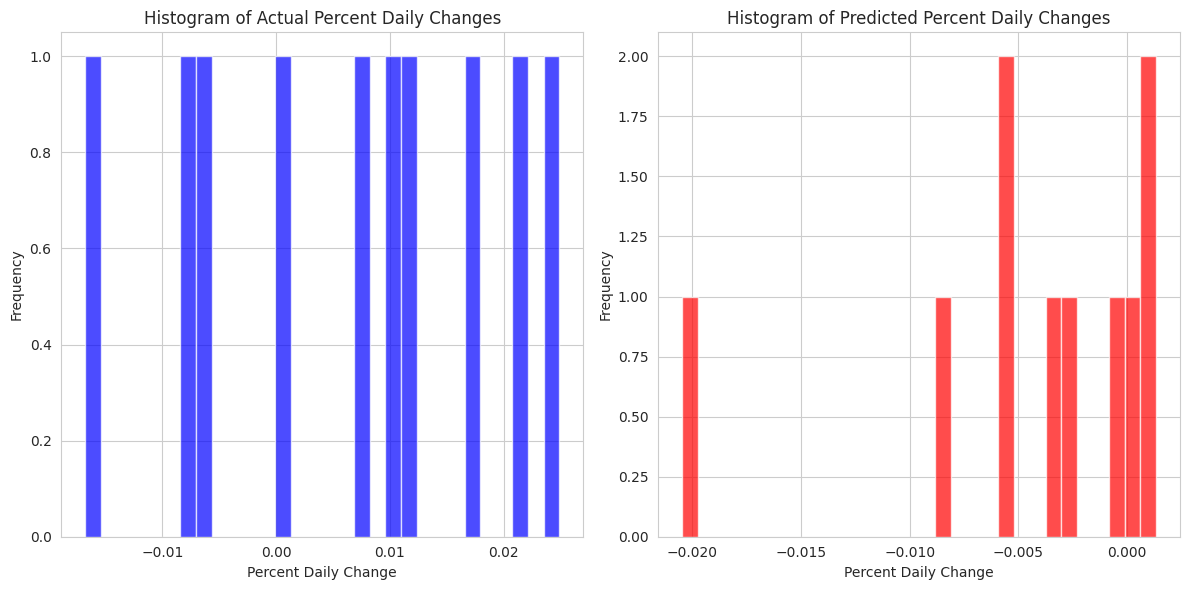

In [59]:
plt.figure(figsize=(12, 6))

# Histogram for actual values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(Y_test, bins=30, alpha=0.7, color='blue')
plt.xlabel('Percent Daily Change')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Percent Daily Changes')

# Histogram for predicted values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(y_pred, bins=30, alpha=0.7, color='red')
plt.xlabel('Percent Daily Change')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Percent Daily Changes')

# Show the plot
plt.tight_layout()
plt.show()

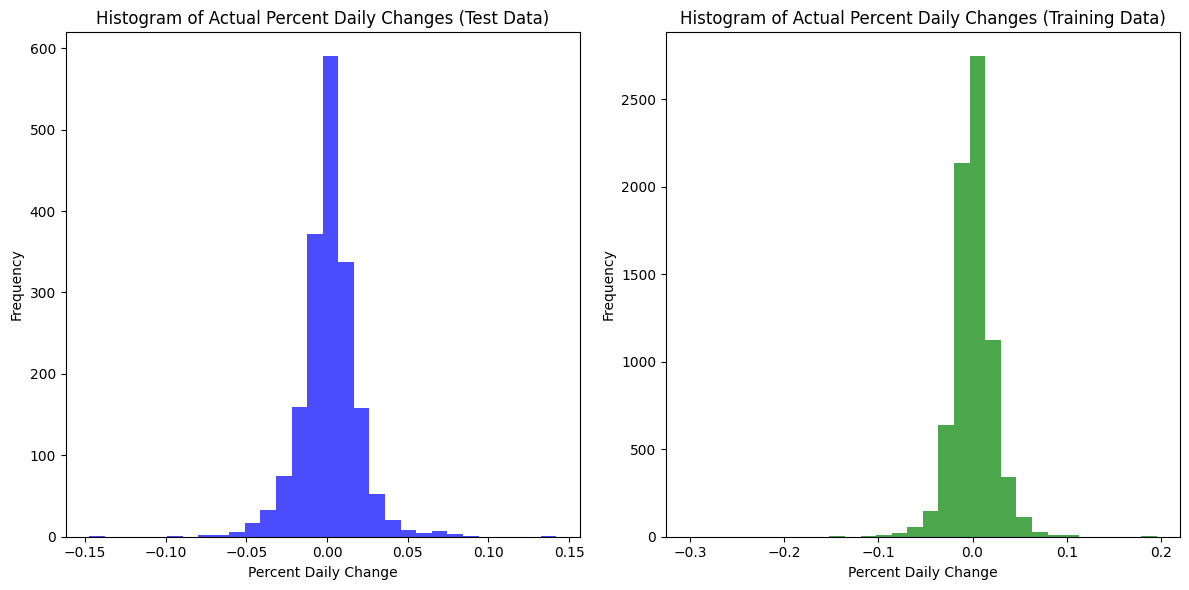

In [11]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Histogram for actual values (Test Data)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(Y_test, bins=30, alpha=0.7, color='blue')
plt.xlabel('Percent Daily Change')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Percent Daily Changes (Test Data)')

# Histogram for actual values (Training Data)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(Y_train, bins=30, alpha=0.7, color='green')
plt.xlabel('Percent Daily Change')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Percent Daily Changes (Training Data)')

# Show the plot
plt.tight_layout()
plt.show()

## Training data

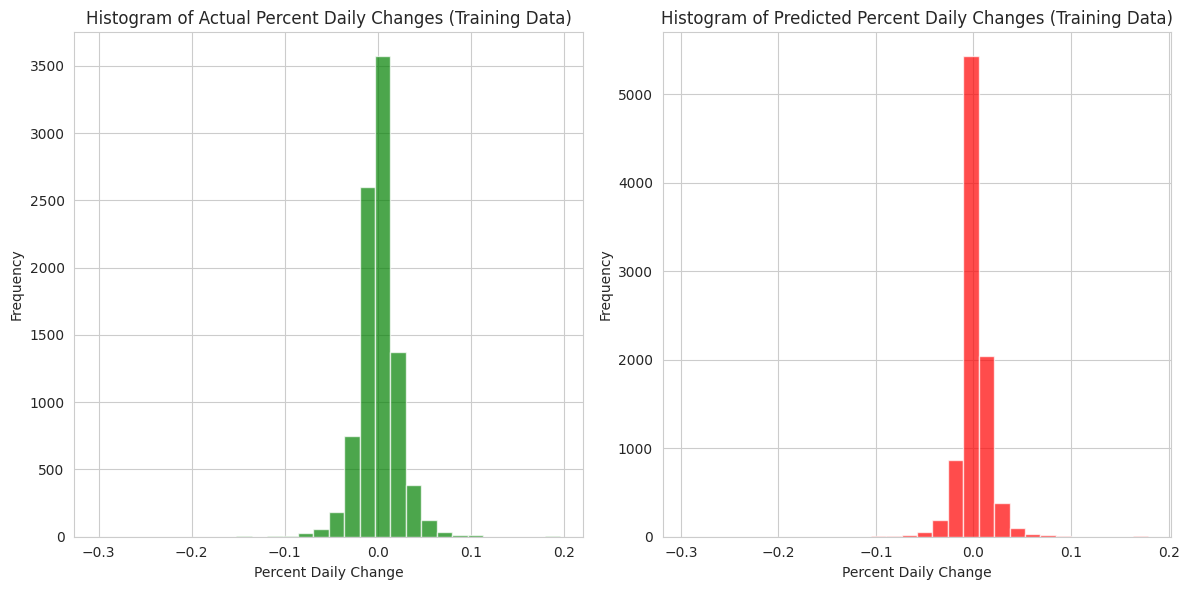

In [48]:
# Generate predictions for the training data
y_pred_train = reg.predict(X_train)

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Histogram for actual values (Training Data)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(Y_train, bins=30, alpha=0.7, color='green')
plt.xlabel('Percent Daily Change')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Percent Daily Changes (Training Data)')

# Histogram for predicted values (Training Data)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(y_pred_train, bins=30, alpha=0.7, color='red')
plt.xlabel('Percent Daily Change')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Percent Daily Changes (Training Data)')

# Show the plot
plt.tight_layout()
plt.show()


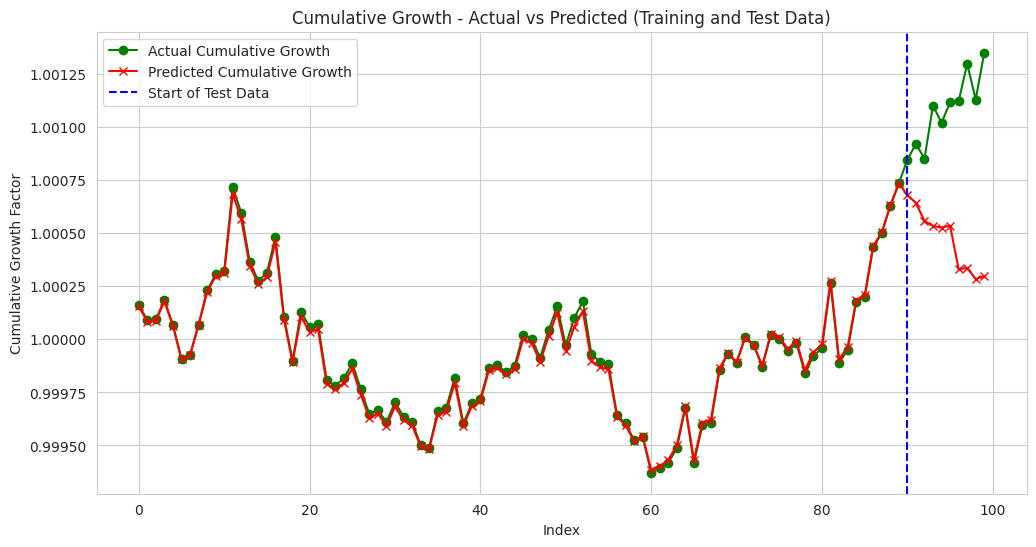

In [74]:
y_pred_train = reg.predict(X_train)

# Concatenate training and test predictions, and actual values
combined_pred = np.concatenate([y_pred_train, y_pred])
combined_actual = np.concatenate([Y_train, Y_test])

# Convert to growth factors
growth_factors_combined_pred = 1 + combined_pred / 100
growth_factors_combined_actual = 1 + combined_actual / 100

# Calculate cumulative product
cumulative_growth_pred = np.cumprod(growth_factors_combined_pred)
cumulative_growth_actual = np.cumprod(growth_factors_combined_actual)

# Create an index for the entire dataset
combined_index = np.arange(len(combined_pred))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(combined_index, cumulative_growth_actual, label='Actual Cumulative Growth', marker='o', color='green')
plt.plot(combined_index, cumulative_growth_pred, label='Predicted Cumulative Growth', marker='x', color='red')

# Add a line to indicate where test data begins
test_data_start = len(Y_train)
plt.axvline(x=test_data_start, color='blue', linestyle='--', label='Start of Test Data')

plt.xlabel('Index')
plt.ylabel('Cumulative Growth Factor')
plt.title('Cumulative Growth - Actual vs Predicted (Training and Test Data)')
plt.legend()
plt.show()

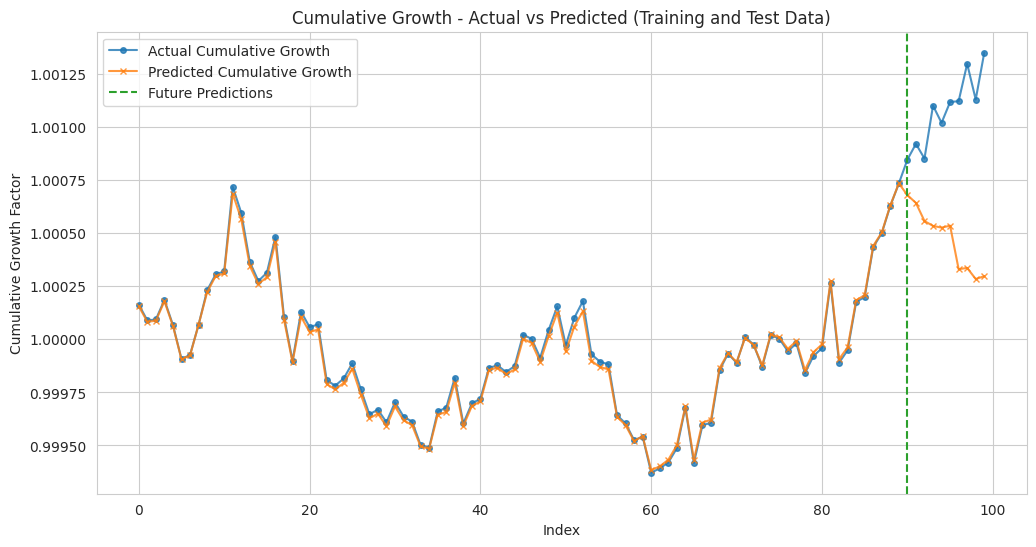

In [75]:
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")

# Concatenate training and test predictions, and actual values
combined_pred = np.concatenate([y_pred_train, y_pred])
combined_actual = np.concatenate([Y_train, Y_test])

# Convert to growth factors
growth_factors_combined_pred = 1 + combined_pred / 100
growth_factors_combined_actual = 1 + combined_actual / 100

# Calculate cumulative product
cumulative_growth_pred = np.cumprod(growth_factors_combined_pred)
cumulative_growth_actual = np.cumprod(growth_factors_combined_actual)

# Create an index for the entire dataset
combined_index = np.arange(len(combined_pred))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(combined_index, cumulative_growth_actual, label='Actual Cumulative Growth', color='#1f77b4', lw=1.5, alpha=0.8, marker='o', markersize=4)
plt.plot(combined_index, cumulative_growth_pred, label='Predicted Cumulative Growth', color='#ff7f0e', lw=1.5, alpha=0.8, marker='x', markersize=4)

# Add a line to indicate where test data begins
test_data_start = len(Y_train)
plt.axvline(x=test_data_start, color='#2ca02c', linestyle='--', lw=1.5, label='Future Predictions')

plt.xlabel('Index')
plt.ylabel('Cumulative Growth Factor')
plt.title('Cumulative Growth - Actual vs Predicted (Training and Test Data)')
plt.legend()
plt.show()

In [62]:
y_pred

array([-0.0054742 , -0.00370283, -0.00851496, -0.00230258, -0.00079189,
        0.00090399, -0.02048673,  0.00059362, -0.00522938,  0.00134471],
      dtype=float32)

# Test the Models Class

In [6]:
from ML_Models import *

In [5]:
hyperparameters = {
    'learning_rate': 0.01,
    'epochs': 10,
    'n_estimators':1000,
    'batch_size': 32,
    'lstm_units': 50,
    'dense_units': 64,
    'dropout_rate': 0.2,
    'L2_regularize': False,
    'L1_regularize': False,
    'test_split': 0.1,
    'validation_split': 0.4,
    'optimizer': 'Adam',
    'wandb': False,
    'save': False,
    'name': 'test',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'MSFT',
    'model_architecture': 'Gradient Boosting',
    'objective':'binary:logistic',
    'input_shape':(1, 12)
}

In [13]:
num_features = FEATURES.columns.shape[0]
input_shape = (1, num_features)
input_shape

(1, 12)

In [7]:
xgb_model = Binary_XGBoost(**hyperparameters)

In [8]:
xgb_model.train(X_train, Y_train, X_val, Y_val)

[0]	validation_0-logloss:0.65540	validation_0-error:0.37160	validation_1-logloss:0.65810	validation_1-error:0.37696
[100]	validation_0-logloss:0.44407	validation_0-error:0.19189	validation_1-logloss:0.47973	validation_1-error:0.20876
[200]	validation_0-logloss:0.38500	validation_0-error:0.17350	validation_1-logloss:0.44090	validation_1-error:0.20552
[300]	validation_0-logloss:0.36005	validation_0-error:0.16092	validation_1-logloss:0.42561	validation_1-error:0.20281
[400]	validation_0-logloss:0.34357	validation_0-error:0.14902	validation_1-logloss:0.41823	validation_1-error:0.20498
[500]	validation_0-logloss:0.32946	validation_0-error:0.13604	validation_1-logloss:0.41798	validation_1-error:0.20606
[600]	validation_0-logloss:0.31763	validation_0-error:0.12698	validation_1-logloss:0.41926	validation_1-error:0.20498
[700]	validation_0-logloss:0.30408	validation_0-error:0.11264	validation_1-logloss:0.42202	validation_1-error:0.20443
[800]	validation_0-logloss:0.29375	validation_0-error:0.10

In [9]:
pred = xgb_model.predict(X_test, Y_test)

In [10]:
pred = pred['predictions']

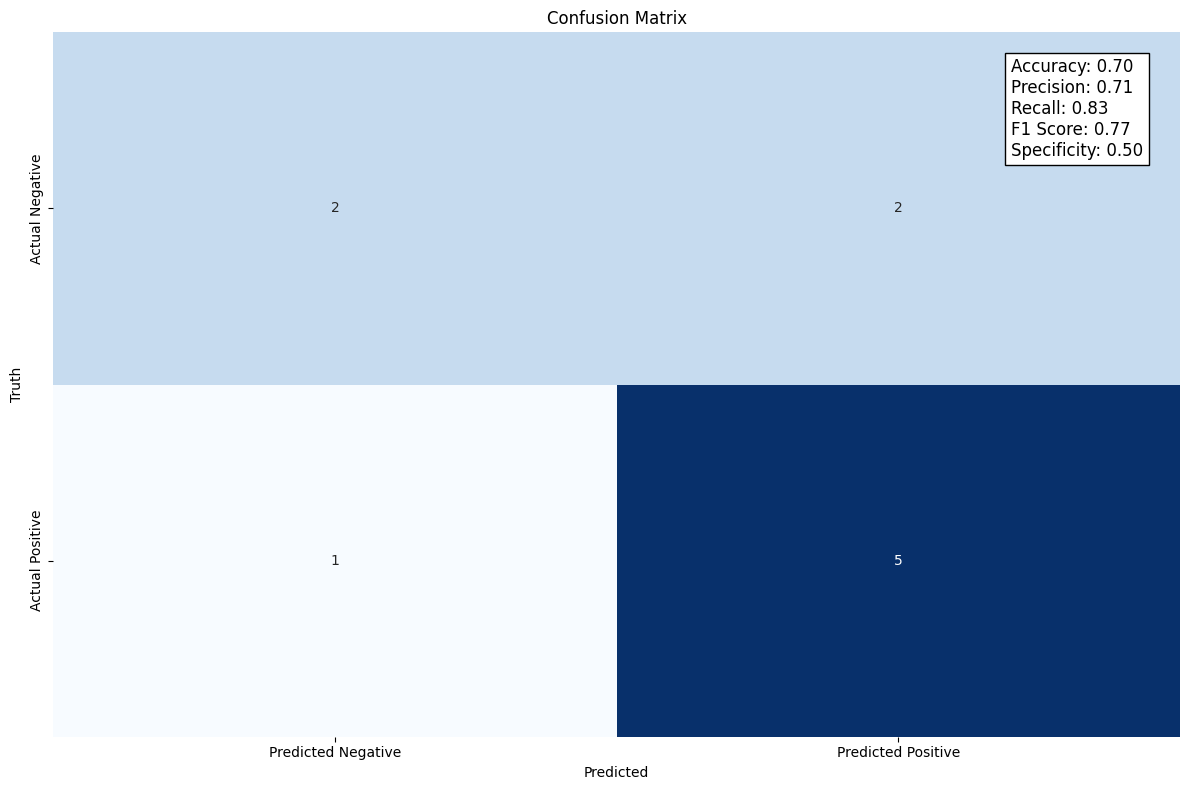

In [11]:
error_matrix(Y_test, pred)

## LSTM Test

In [19]:
hyperparameters = {
    'learning_rate': 0.01,
    'epochs': 20,
    'batch_size': 32,
    'lstm_units': 50,
    'dense_units': 64,
    'dropout_rate': 0.2,
    'L2_regularize': False,
    'L1_regularize': False,
    'test_split': 0.1,
    'validation_split': 0.4,
    'optimizer': 'Adam',
    'wandb': False,
    'save': False,
    'name': 'test',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'MSFT',
    'model_architecture': 'Gradient Boosting',
    'objective':'binary:logistic',
    'input_shape':(1, 12)
}

In [20]:
lstm = Binary_LSTM(**hyperparameters)

In [8]:
lstm.epochs

10

In [21]:
history = lstm.train(X_train, Y_train, X_val, Y_val)

Epoch 1/20
229/229 [==============================] - 6s 6ms/step - loss: 0.5714 - accuracy: 0.7403 - val_loss: 0.4909 - val_accuracy: 0.7875
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.4594 - accuracy: 0.7789 - val_loss: 0.4574 - val_accuracy: 0.7832
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.4260 - accuracy: 0.7838 - val_loss: 0.4643 - val_accuracy: 0.7635
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.4204 - accuracy: 0.7816 - val_loss: 0.4385 - val_accuracy: 0.7810
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.4180 - accuracy: 0.7836 - val_loss: 0.4869 - val_accuracy: 0.7531
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4155 - accuracy: 0.7834 - val_loss: 0.5122 - val_accuracy: 0.7307
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.4148 - accuracy: 0.7825 - val_loss: 0.4630 - val_accuracy: 0.7744
Epoch 

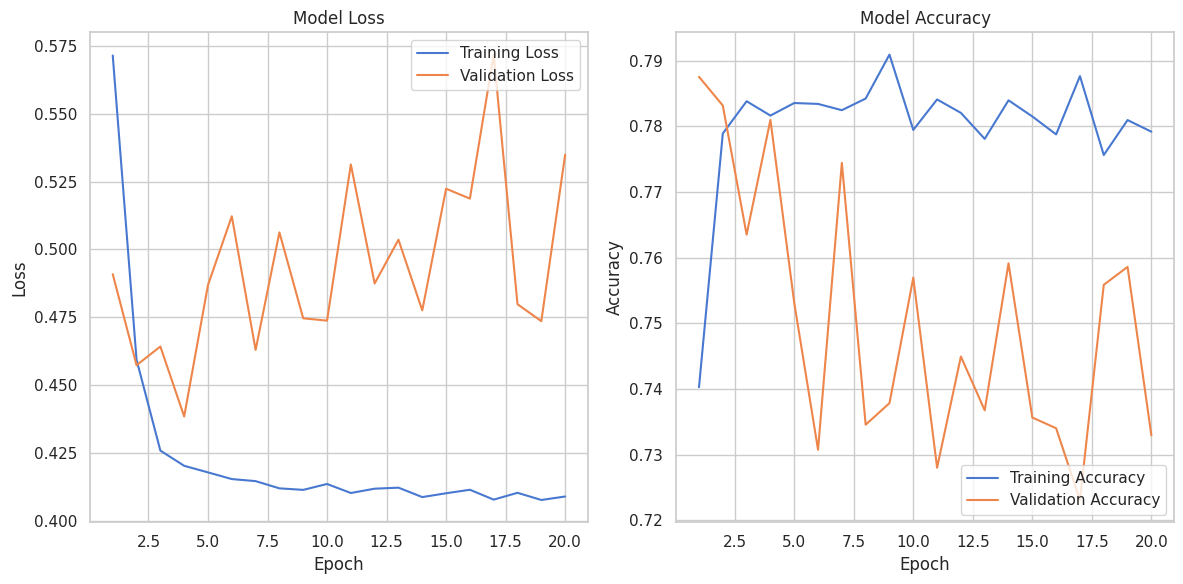

In [22]:
plot(history)

In [27]:
pred = lstm.predict(X_test, Y_test, threshold=0.2)
pred = pred['predictions']

4/4 [==============================] - 0s 12ms/step


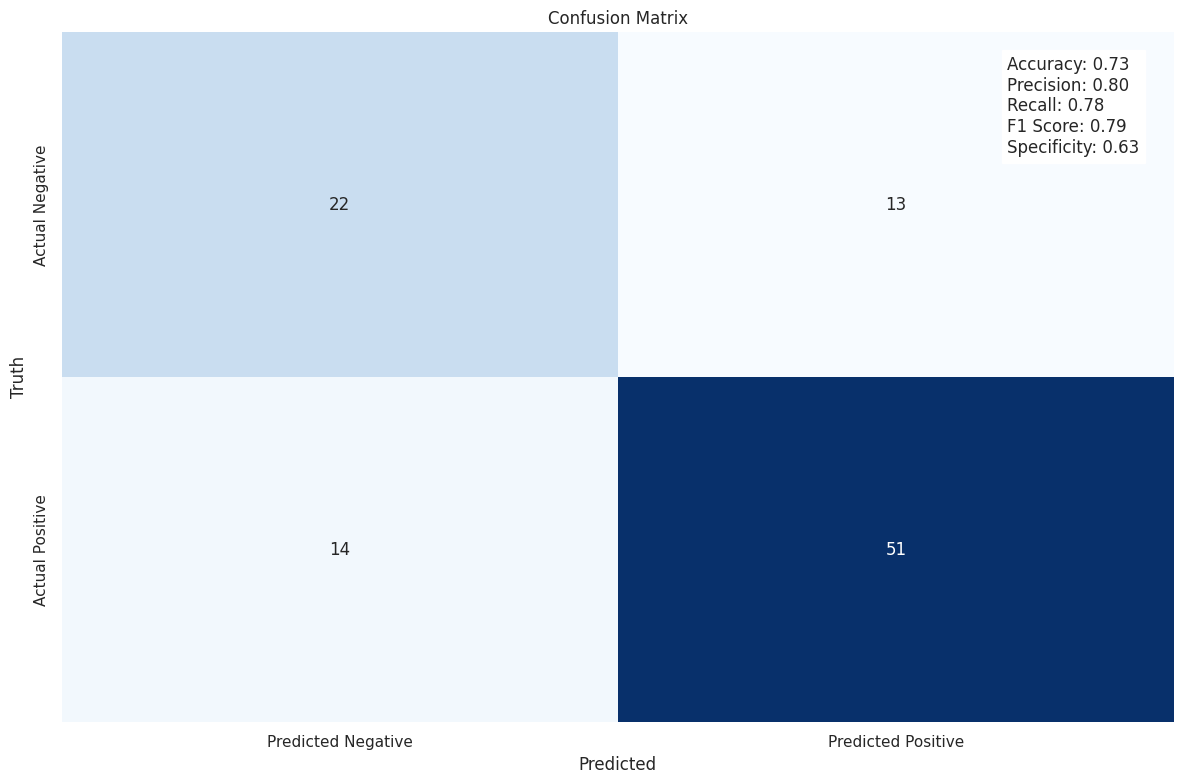

In [28]:
error_matrix(Y_test, pred)

## Test RNN

In [18]:
rnn = Binary_RNN(**hyperparameters)

In [19]:
rnn.train(X_train, Y_train, X_val, Y_val)

Epoch 1/10
232/232 [==============================] - 6s 10ms/step - loss: 0.5999 - accuracy: 0.7473 - val_loss: 0.5950 - val_accuracy: 0.7875
Epoch 2/10
232/232 [==============================] - 1s 3ms/step - loss: 0.5863 - accuracy: 0.7663 - val_loss: 0.5995 - val_accuracy: 0.7015
Epoch 3/10
232/232 [==============================] - 1s 3ms/step - loss: 0.5638 - accuracy: 0.7693 - val_loss: 0.5775 - val_accuracy: 0.7528
Epoch 4/10
232/232 [==============================] - 1s 3ms/step - loss: 0.5220 - accuracy: 0.7753 - val_loss: 0.5334 - val_accuracy: 0.7566
Epoch 5/10
232/232 [==============================] - 1s 3ms/step - loss: 0.4651 - accuracy: 0.7826 - val_loss: 0.4448 - val_accuracy: 0.7912
Epoch 6/10
232/232 [==============================] - 1s 3ms/step - loss: 0.4399 - accuracy: 0.7754 - val_loss: 0.4379 - val_accuracy: 0.7885
Epoch 7/10
232/232 [==============================] - 1s 3ms/step - loss: 0.4354 - accuracy: 0.7785 - val_loss: 0.4366 - val_accuracy: 0.7912
Epoch

In [20]:
pred = rnn.predict(X_test, Y_test)
pred = pred['predictions']

1/1 [==============================] - 1s 510ms/step


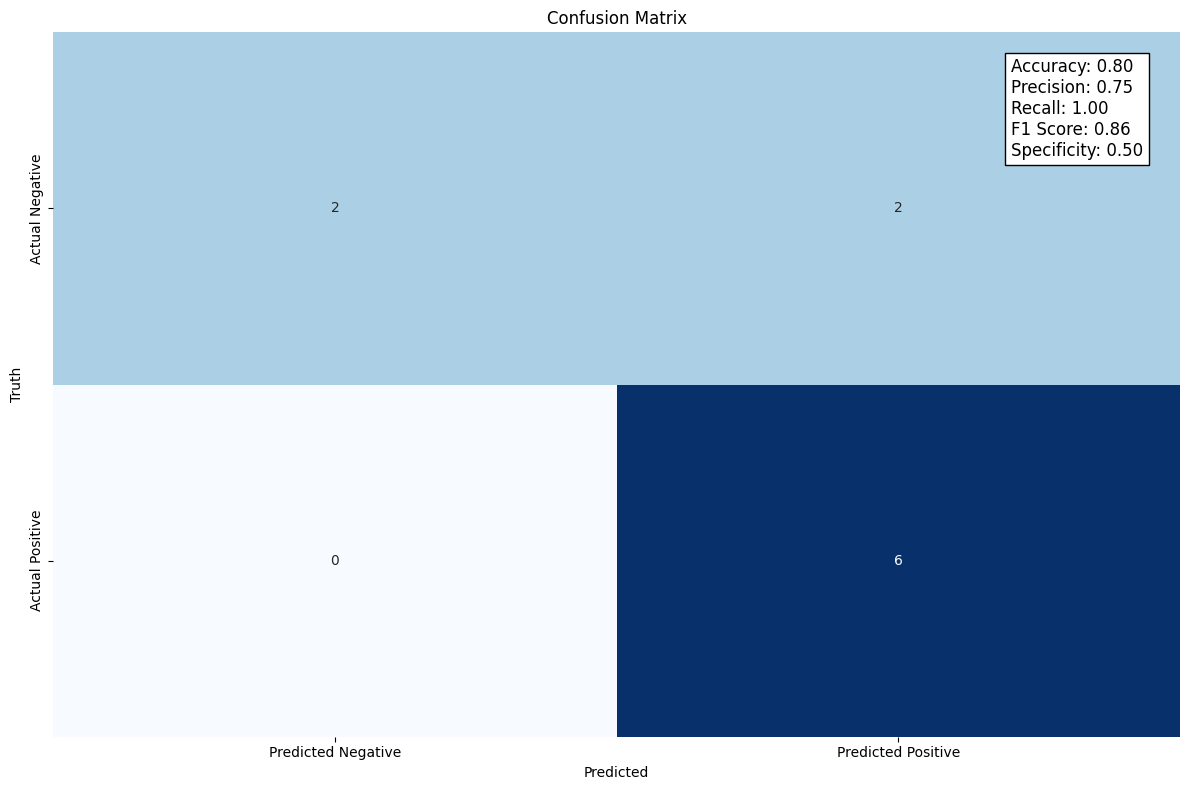

In [21]:
error_matrix(Y_test, pred)

## Test CNN

In [7]:
periods = 1
num_features = FEATURES.columns.shape[0]
input_shape = (periods, num_features)
input_shape

(1, 12)

In [27]:
hyperparameters = {
    'learning_rate': 0.01,
    'epochs': 10,
    'batch_size': 32,
    'lstm_units': 50,
    'dense_units': 64,
    'dropout_rate': 0.2,
    'L2_regularize': False,
    'L1_regularize': False,
    'test_split': 0.1,
    'validation_split': 0.4,
    'optimizer': 'Adam',
    'wandb': False,
    'save': False,
    'name': 'test',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'MSFT',
    'model_architecture': 'Gradient Boosting',
    'objective':'binary:logistic',
    'input_shape':(10, 12)
}

In [28]:
cnn = Binary_CNN(**hyperparameters)

In [29]:
cnn.train(X_train, Y_train, X_val, Y_val)

Epoch 1/10
229/229 [==============================] - 3s 7ms/step - loss: 0.4748 - accuracy: 0.7494 - val_loss: 0.4445 - val_accuracy: 0.7835
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.4458 - accuracy: 0.7620 - val_loss: 0.4207 - val_accuracy: 0.7769
Epoch 3/10
229/229 [==============================] - 1s 4ms/step - loss: 0.4424 - accuracy: 0.7669 - val_loss: 0.4164 - val_accuracy: 0.7797
Epoch 4/10
229/229 [==============================] - 1s 7ms/step - loss: 0.4388 - accuracy: 0.7675 - val_loss: 0.4256 - val_accuracy: 0.7786
Epoch 5/10
229/229 [==============================] - 1s 6ms/step - loss: 0.4446 - accuracy: 0.7631 - val_loss: 0.4302 - val_accuracy: 0.7495
Epoch 6/10
229/229 [==============================] - 2s 7ms/step - loss: 0.4404 - accuracy: 0.7707 - val_loss: 0.4314 - val_accuracy: 0.7544
Epoch 7/10
229/229 [==============================] - 2s 8ms/step - loss: 0.4400 - accuracy: 0.7695 - val_loss: 0.4227 - val_accuracy: 0.7720
Epoch 

In [32]:
Xt, Yt = transform_features_CNN_overlapping(X_test, Y_test)

preds = (cnn.model.predict(Xt)>0.5).astype(int).flatten()

3/3 [==============================] - 0s 4ms/step


In [36]:
len(preds)

91

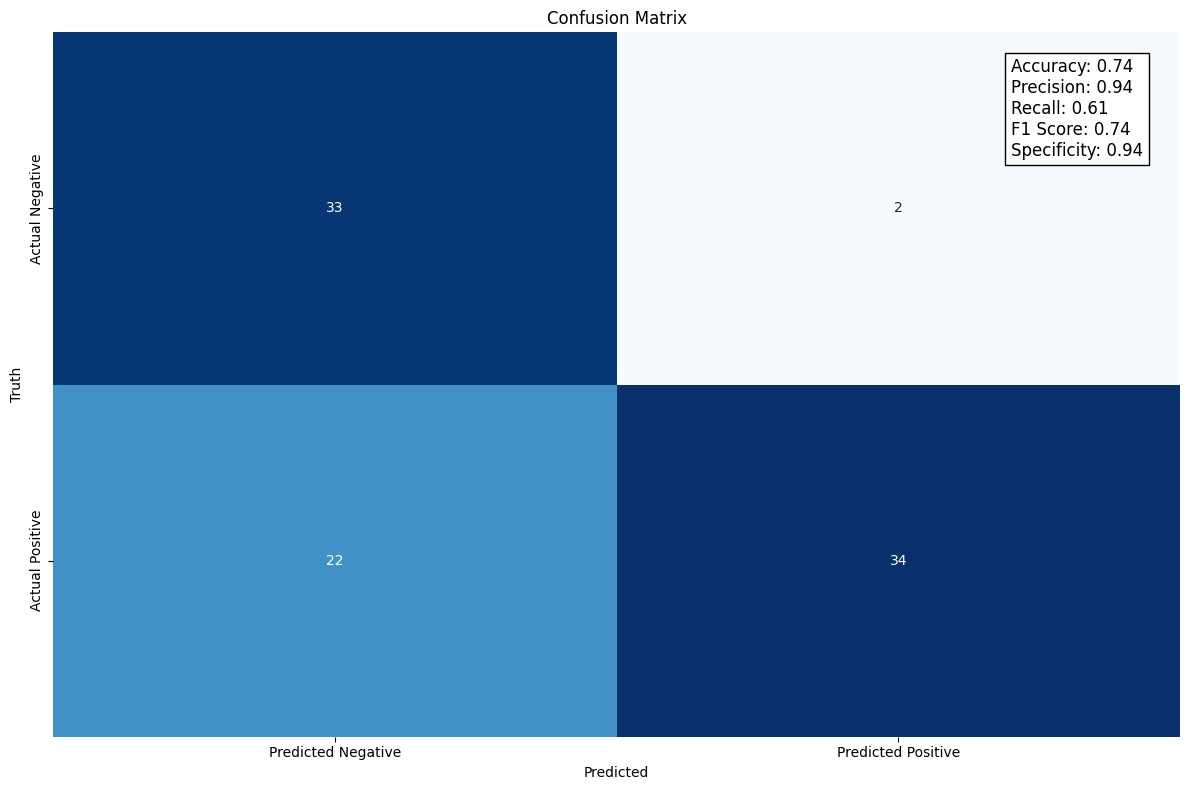

In [33]:
error_matrix(Yt, preds)

In [21]:
pred = cnn.predict(X_val, Y_val)
pred = pred['predictions']

58/58 [==============================] - 0s 3ms/step


ValueError: ignored

In [25]:
Y_val

Date
2016-07-21    1
2016-07-22    0
2016-07-25    0
2016-07-26    1
2016-07-27    1
             ..
2023-11-20    0
2023-11-21    1
2023-11-22    1
2023-11-24    0
2023-11-27    0
Name: TARGET, Length: 1851, dtype: int64

In [20]:
preds = (cnn.model.predict(Xv)>0.5).astype(int).flatten()

6/6 [==============================] - 0s 4ms/step


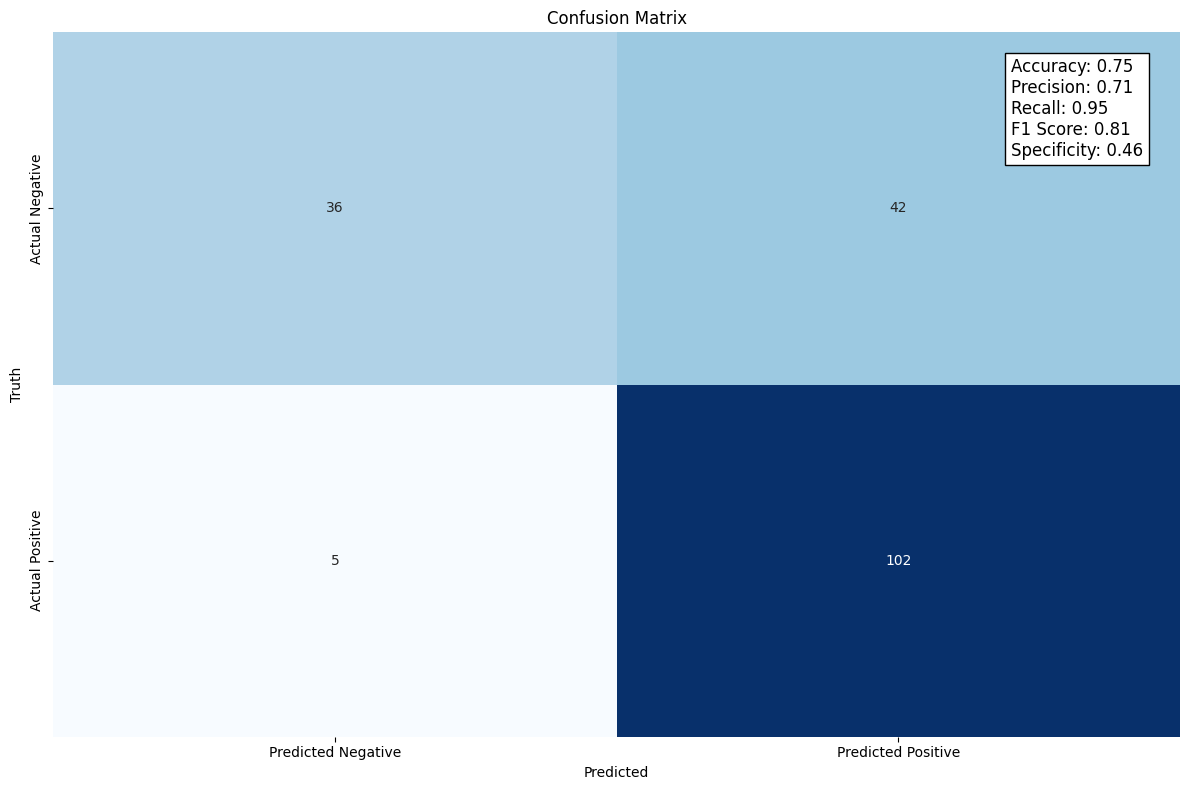

In [24]:
error_matrix(Yv, preds)

In [15]:
Xv, Yv = transform_features_CNN(X_val, Y_val)

In [16]:
Xv

array([[[0.13244845, 0.75      , 0.54545455, ..., 0.06976169,
         0.57578368, 0.04838434],
        [0.13428231, 1.        , 0.54545455, ..., 0.05144295,
         0.57050794, 0.04709493],
        [0.13466335, 0.        , 0.54545455, ..., 0.040967  ,
         0.62683652, 0.00726002],
        ...,
        [0.1343061 , 0.        , 0.63636364, ..., 0.0520619 ,
         0.58921235, 0.05176242],
        [0.1343061 , 0.25      , 0.63636364, ..., 0.06508703,
         0.58896202, 0.06049346],
        [0.13523497, 0.5       , 0.63636364, ..., 0.03367314,
         0.5925146 , 0.03300196]],

       [[0.13623528, 0.75      , 0.63636364, ..., 0.03506586,
         0.60196978, 0.05795776],
        [0.13759278, 1.        , 0.63636364, ..., 0.04899908,
         0.59184917, 0.04385434],
        [0.13783092, 0.        , 0.63636364, ..., 0.03732415,
         0.58697977, 0.03694804],
        ...,
        [0.13797381, 0.        , 0.63636364, ..., 0.05067506,
         0.55584532, 0.02559755],
        [0.1

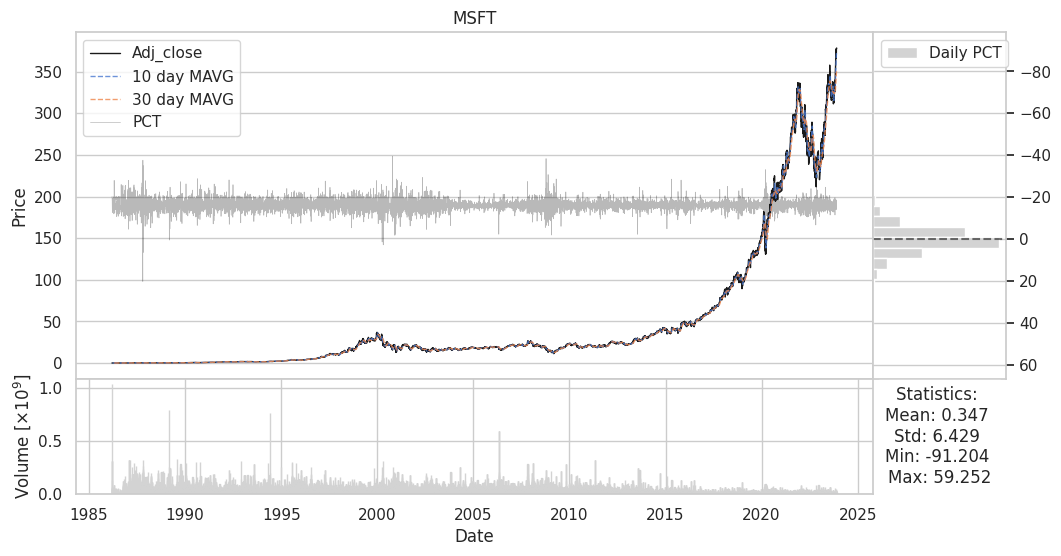

CPU times: user 23.6 s, sys: 551 ms, total: 24.2 s
Wall time: 24 s


<Figure size 640x480 with 0 Axes>

In [32]:
%%time
data.quick_view()